In [1]:
%matplotlib inline

# Basic micromagnetics
The goal of micromagnetics is to compute the equilibrium magnetization configuration of a given magnetic sample. Its physical shape is modeled by the mesh. The size of the mesh cells is limited by a physical length scale originating from the ferromagnetic exchange interaction and we need to compute the magnetization configuration that arises, when an external magnetic field (the Zeeman field) is applied along a certain spatial direction. The micromagnetic moments $\vec{m}$ sitting on the sites of the mesh nodes will start to align themselves with the external field, but are also subject to the nearest-neighbour interaction from the exchange. The equation of motion describing the magnetization reversal is the Landau-Lifshitz-Gilbert equation

$$
\frac{d\vec{m}}{dt} = -\frac{\gamma}{1 + \alpha^2}\left(\vec{m} \times \vec{H}_{\mathrm{eff}}\right) - \frac{\gamma\alpha}{1 + \alpha^2} \left[\vec{m} \times \left(\vec{m} \times \vec{H}_{\mathrm{eff}}\right)\right]
$$

given here in its explicit form with the gyromagnetic ration $\gamma$ and the Gilbert damping parameter $\alpha$. $\vec{H}_{\mathrm{eff}}$ is the effective field acting on the magnetic moment, which in reality consists of more terms than the Zeeman and exchange fields only. It is computed from the functional derivative of the total magnetic energy density $w (\vec{m})$

$$
\vec{H}_{\mathrm{eff}}(\vec{m}) = -\frac{1}{\mu_0 M_S}\frac{\delta w (\vec{m})}{\delta \vec{m}}
$$

where

$$
w (\vec{m}) = A(\nabla \vec{m})^2 - \mu_0 M_S \vec{m}\cdot \vec{H}.
$$

The used constants are the vacuum permeability $\mu_0$, the saturation magnetization $M_S$, the ferromagnetic exchange constant $A$ and the Zeeman field $\vec{H}$.


In [40]:
import fenics as df
import numpy as np
import matplotlib.pyplot as plt

# Material parameters
Ms = 8.6e5  # saturation magnetisation (A/m)
alpha = 0.1  # Gilbert damping
gamma = 2.211e5  # gyromagnetic ratio
A = 1e-11 # exchange constant (J/m)
#A = 0
D = 0*1.58e-3 # DMI constant (FeGe: D = 1.58e-3 J/m²)
K = 0*5e3 # anisotropy constant (Co: K = 4.5e5 J/m³)

# External magnetic field.
B = 0.1  # (T)
mu0 = 4 * np.pi * 1e-7  # vacuum permeability

# Zeeman field
H = Ms / 2 * df.Constant((0,0,1))
# easy axis
ea = df.Constant((0,1,1))
# meaningful time period is of order of nano seconds
dt = 1e-12

# mesh parameters
d = 100e-9
thickness = 100e-9
nx = ny = 20
nz = 10

# create mesh
p1 = df.Point(0, 0, 0)
p2 = df.Point(d, d, thickness)
mesh = df.BoxMesh(p1, p2, nx, ny, nz)

# define function space for magnetization
V = df.VectorFunctionSpace(mesh, "CG", 1, dim=3)
v = df.TestFunction(V)
u = df.TrialFunction(V)

# define initial M and normalise
m = df.Function(V)

def effective_field(m, volume=None):
    w_Zeeman = - mu0 * Ms * df.dot(m, H)
    w_exchange = A  * df.inner(df.grad(m), df.grad(m))
    w_DMI = D * df.inner(m, df.curl(m))
    w_ani = - K * df.inner(m, ea)**2
    w = w_Zeeman + w_exchange + w_DMI + w_ani
    return -1/(mu0*Ms) * df.derivative(w*df.dx, m)

# Effective field
Heff_form = effective_field(m)

In [41]:
# Preassemble projection Matrix
Amat = df.assemble(df.dot(u, v)*df.dx)

LU = df.LUSolver()
LU.set_operator(Amat)
Heff = df.Function(V)

def compute_dmdt(m):
    """Convenience function that does all in one go"""

    # Assemble RHS
    b = df.assemble(Heff_form)

    # Project onto Heff
    LU.solve(Heff.vector(), b)

    LLG = -gamma/(1+alpha*alpha)*df.cross(m, Heff) - alpha*gamma/(1+alpha*alpha)*df.cross(m, df.cross(m, Heff))

    result = df.assemble(df.dot(LLG, v)*df.dP)
    return result.array()

# function for integration of system of ODEs

def rhs_micromagnetic(m_vector_array, t, counter=[0]):
    assert isinstance(m_vector_array, np.ndarray)
    m.vector()[:] = m_vector_array[:]

    dmdt = compute_dmdt(m)
    return dmdt

## Integrate ODEs with scipy.integrate

In [42]:
%%time
from scipy.integrate import odeint
m_init = df.Constant((1, 0, 0))
m = df.interpolate(m_init, V)
ts = np.linspace(0, 5e-10, 100)

# empty call of time integrator, just to get FEniCS to cache all forms etc
rhs_micromagnetic(m.vector().array(), 0)

CPU times: user 910 ms, sys: 70 ms, total: 980 ms
Wall time: 978 ms


In [43]:
%%time 

ms = odeint(rhs_micromagnetic, y0=m.vector().array(), t=ts, rtol=1e-10, atol=1e-10)

CPU times: user 3.75 s, sys: 70 ms, total: 3.82 s
Wall time: 3.83 s


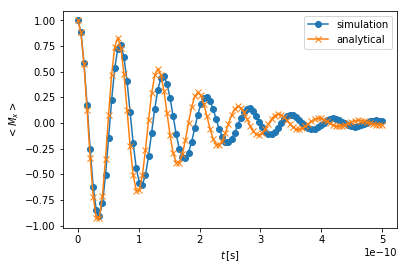

In [44]:
import pylab

def macrospin_analytic_solution(alpha, gamma, H, t_array):
    """
    Computes the analytic solution of magnetisation x component
    as a function of time for the macrospin in applied external
    magnetic field H.

    Source: PhD Thesis Matteo Franchin,
    http://eprints.soton.ac.uk/161207/1.hasCoversheetVersion/thesis.pdf,
    Appendix B, page 127

    """
    t0 = 1 / (gamma * alpha * H) * \
        np.log(np.sin(np.pi / 2) / (1 + np.cos(np.pi / 2)))
    mx_analytic = []
    for t in t_array:
        phi = gamma * H * t                                     # (B16)
        costheta = np.tanh(gamma * alpha * H * (t - t0))        # (B17)
        sintheta = 1 / np.cosh(gamma * alpha * H * (t - t0))    # (B18)
        mx_analytic.append(sintheta * np.cos(phi))

    return np.array(mx_analytic)

mx_analytic = macrospin_analytic_solution(alpha, gamma, Ms/2, ts)

tmp2 = ms[:,0:1]  # might be m_x, m_y, m_z of first vector
pylab.plot(ts, tmp2, 'o-')
pylab.plot(ts, mx_analytic, 'x-')
pylab.legend(['simulation', 'analytical'])
pylab.xlabel('$t\,$[s]')
pylab.ylabel('$<M_x>$')

max deviation: 0.382572084097


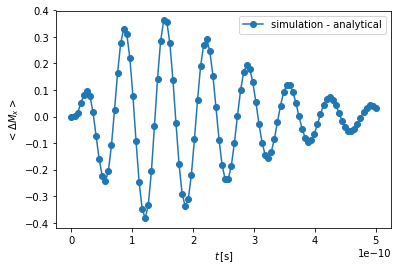

In [45]:
difference = tmp2[:,0] - mx_analytic
print("max deviation: {}".format(max(abs(difference))))
pylab.plot(ts, difference, 'o-')
pylab.legend(['simulation - analytical'])
pylab.xlabel('$t\,$[s]')
pylab.ylabel('$<\Delta M_x>$')